# LASP coding challenge

Tasks:

* Calculate the irradiance in watts/m^2 and compare the scan data.
* Provide plots of your results along with your code. 
* Specifically plot the region around the two emission lines at ~180nm.
* What are your thoughts?

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.rcParams.update({'font.size': 11})

In [2]:
# Define data directory and filenames
DATA_DIR = '../dataFiles/'

temperature_file = os.path.join(DATA_DIR, 'detectorTemp.txt')
distance_doppler_file = os.path.join(DATA_DIR, 'distanceAndDoppler.txt')
telemetry_file = os.path.join(DATA_DIR, 'instrumentTelemetry.txt')
integration_file = os.path.join(DATA_DIR, 'integrationTime.txt')
plans_file = os.path.join(DATA_DIR, 'plans.txt')
spectrum_file = os.path.join(DATA_DIR, 'referenceSpectrum.txt')

In [3]:
# The grating equation, calculated by wavelength
def calculateWavelength(gratingPosition):
    offset = 239532.38
    stepSize = 2.4237772022101214E-6
    d = 277.77777777777777
    phiGInRads = 0.08503244115716374
    ang1 = (offset - gratingPosition) * stepSize
    # wavelength in nanometers
    wavelength = 2.0 * d * np.sin(ang1) * np.cos(phiGInRads / 2.0)
    return wavelength

In [4]:
# Calculate counts per second per area
def countsPerSecondPerArea(counts, timeInMillisecs):
    # integration time in seconds converted from milliseconds
    integrationTime = timeInMillisecs/1000.
    cr = counts / integrationTime    # counts per second
    apArea = .01   # aperature area in cm^2
    photonsPerSecondPerCm2 = cr / apArea    # units photons/sec/cm^2
    return photonsPerSecondPerCm2

In [5]:
# Calculate watts per meter^2
def wattsPerM2(wavelength, photonsPerSecondPerCm2):
    wavelengthInMeters = wavelength/1.E9 # convert to meters from nm
    h = 6.62606957E-34  # units [m2 * kg / s]
    c = 299792458.0     # units [m/s]
    energyPerPhoton = h * c / wavelengthInMeters
    wattsPerM2 = photonsPerSecondPerCm2 * 1.e2 * 1.e2 * energyPerPhoton   # units [watts/m^2]
    return(wattsPerM2)

In [6]:
# Plot a dataframe
def plotDataframe(df):
    colors = ['r', 'g', 'b', 'c', 'm'] # colors to plot experiment regions
    # for each column after the first, plot against time
    for col in range(1, len(df.columns)):
        fig, ax = plt.subplots()
        # plot the data
        ax.plot(df.ix[:,0], df.ix[:,col], color = 'black') 
        # plot the experiment times as blocks of color
        for j in range(df_plans.shape[0]):
            ax.axvspan(df_plans.startTime[j], df_plans.endTime[j], 
                       alpha=0.3, label=df_plans.planName[j], color = colors[j])
        plt.legend()
        plt.show()

In [7]:
# Remove spaces from column names
# Necessary because I had problem with key errors
def fixColumnNames(columns):
    columns_fix = [col.strip() for col in columns]
    return columns_fix

In [8]:
def exploreDataframe(df):
    # Explore a dataframe to see shape, top few rows, and statistics
    print 'Shape: \n', df.shape, '\n'
    print 'Header: \n', df.head(), '\n'
    print 'Descriptive statistics: \n', df.describe(), '\n'
    # Remove spaces from column names to prevent key errors later
    df.columns = fixColumnNames(df.columns)
    plotDataframe(df)
    return df

In [9]:
# Interpolate values to match observations times
def interpOnTime(x, y, x_new, kind):
    f = interp1d(x, y, kind=kind)
    y_new = f(x_new)
    return y_new

In [10]:
# Plot the calculated spectrum against reference
def plotReferenceSpectrum(df):
    # plot the calculated values
    plt.scatter(df['wavelengthCorrected'], df['irradiance'], 
                marker='.', label = 'calculated')
    # limit to area around emission lines
    plt.xlim([180, 183])
    plt.ylim([0.001,0.007])
    # plot the reference values
    plt.plot(df_refSpectrum.ix[:,0], df_refSpectrum.ix[:,1], 
            color = 'black', label='reference')
    # make it pretty
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Irradiance (watts/m^2)')
    plt.legend()

In [11]:
def calcIrradiance(df):
    # Calculate counts per sec per area, input counts and integration time (ms)
    df['CPSPA'] = countsPerSecondPerArea(df['counts'], df['intTime (ms)'])
    #
    # Plot the dark counts/sec/area vs. temperature
    plt.scatter(df['temp (C)'][df['plan']=='Dark'], df['CPSPA'][df['plan']=='Dark'],
                marker = '.', label = 'data')
    #
    # Fit a polynomial, inputs (x,y,coeff) - I used coeff 3
    p = np.polyfit(df['temp (C)'][df['plan']=='Dark'], df['CPSPA'][df['plan']=='Dark'], 3)
    #
    # Make a function with the polynomial fit
    f_dark = np.poly1d(p)
    #
    # Plot the fitted function
    plt.plot(df['temp (C)'][df['plan']=='Dark'], f_dark(df['temp (C)'][df['plan']=='Dark']),
            color = 'black', label = 'fit')
    plt.legend()
    plt.xlabel('temp (C)')
    plt.ylabel('counts/sec/area')
    plt.show()
    #
    # Correct the counts by subtracting the dark counts for the corresponding temperature
    # Correct counts with distance correction
    df['cpspaCorrected'] = (df['CPSPA'] - f_dark(df['temp (C)']))/df['sunObserverDistanceCorrection']
    #
    # Calculate wavelength, take grating position as input
    df['wavelength'] = calculateWavelength(df['gratPos'])
    #
    # Correct wavelength with Doppler Factor
    df['wavelengthCorrected'] = df['wavelength']/df['sunObserverDopplerFactor']
    #
    # Calculate wattsPerM2, input wavelength and photonsPerSecondPerCm2
    df['irradiance'] = wattsPerM2(df['wavelengthCorrected'], df['cpspaCorrected'])
    return df

# Data Exploration

In this section, I'll read in files and make some simple plots.

### Experiment times
I need to know the time limits of the experiments. This will be relevant later for sorting out what the instrument is doing at each time.

In [12]:
# Make a dataframe for the plans, start times, and end times
# Note: I am only making this global to avoid passing in the
# start and end times for the plots.
global df_plans 
df_plans = pd.read_csv(plans_file)

# Remove spaces from column names, takes column names as input
df_plans.columns = fixColumnNames(df_plans.columns)

print df_plans

             planName     startTime       endTime
0           QuickScan  9.434018e+14  9.434062e+14
1  ConstantWavelength  9.434076e+14  9.434120e+14
2            DownScan  9.434135e+14  9.434179e+14
3                Dark  9.434193e+14  9.434237e+14
4              UpScan  9.434251e+14  9.434295e+14


### Telemetry Data

This is the meat of the science. Let's start just by plotting the counts and grate positions over time.

Shape: 
(41892, 3) 

Header: 
   microsecondsSinceGpsEpoch   gratPos       counts
0               9.434016e+14       0.0  1098.281164
1               9.434016e+14       0.0  1365.455506
2               9.434016e+14       0.0   312.516740
3               9.434016e+14       0.0   405.524092
4               9.434016e+14       0.0   814.117307 

Descriptive statistics: 
       microsecondsSinceGpsEpoch        gratPos        counts
count               4.189200e+04   41892.000000  4.189200e+04
mean                9.434107e+14   77767.512233  8.378350e+08
std                 7.773320e+09   44295.400702  1.355483e+09
min                 9.434016e+14       0.000000  6.872705e+01
25%                 9.434044e+14   95502.268356  2.569820e+08
50%                 9.434084e+14  100788.099172  4.455764e+08
75%                 9.434166e+14  106215.099172  6.922221e+08
max                 9.434295e+14  107214.099172  1.003286e+10 



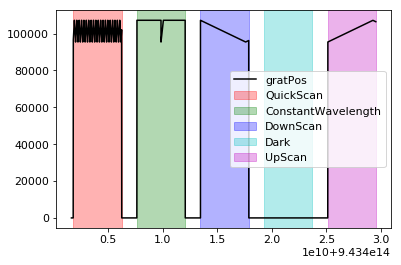

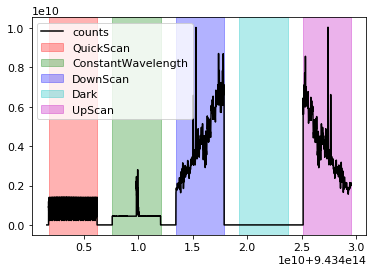

In [13]:
df_telemetry = pd.read_csv(telemetry_file)
df_telemetry = exploreDataframe(df_telemetry)

The first thing I notice is that there are times in the data that are outside of the experiment limits. I'll delve into that later. There's also something anomalous going on in the middle of the constant wavelength experiment.

### Temperature, distance, doppler, and integration time

This is all information I'll use later for corrections and calculations.

In [14]:
# Define dataframes
df_detectorTemp = pd.read_csv(temperature_file)
df_distDoppler = pd.read_csv(distance_doppler_file)
df_integrationTime = pd.read_csv(integration_file)

# List of dataframes
list_df = [df_detectorTemp, df_distDoppler, df_integrationTime]

Shape: 
(43201, 2) 

Header: 
   microsecondsSinceGpsEpoch   temp (C)
0               9.434016e+14  19.498050
1               9.434016e+14  19.496100
2               9.434016e+14  19.494151
3               9.434016e+14  19.492201
4               9.434016e+14  19.490252 

Descriptive statistics: 
       microsecondsSinceGpsEpoch      temp (C)
count               4.320100e+04  43201.000000
mean                9.434232e+14     21.109010
std                 1.247120e+10      0.852835
min                 9.434016e+14     18.998284
25%                 9.434124e+14     20.517350
50%                 9.434232e+14     21.436378
75%                 9.434340e+14     21.843607
max                 9.434448e+14     21.966931 



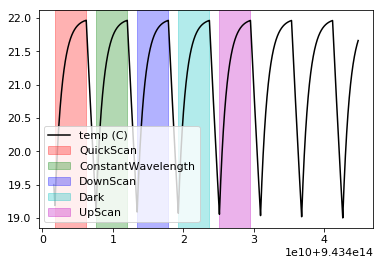

Shape: 
(720, 3) 

Header: 
   microsecondsSinceGpsEpoch   sunObserverDistanceCorrection  \
0               9.434016e+14                        1.027286   
1               9.434017e+14                        1.027289   
2               9.434017e+14                        1.027291   
3               9.434018e+14                        1.027294   
4               9.434019e+14                        1.027297   

    sunObserverDopplerFactor  
0                   1.000009  
1                   1.000010  
2                   1.000010  
3                   1.000011  
4                   1.000012   

Descriptive statistics: 
       microsecondsSinceGpsEpoch   sunObserverDistanceCorrection  \
count               7.200000e+02                      720.000000   
mean                9.434232e+14                        1.027425   
std                 1.247942e+10                        0.000066   
min                 9.434016e+14                        1.027286   
25%                 9.434124e+14  

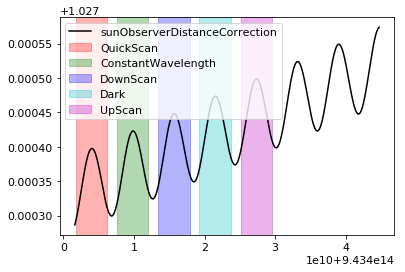

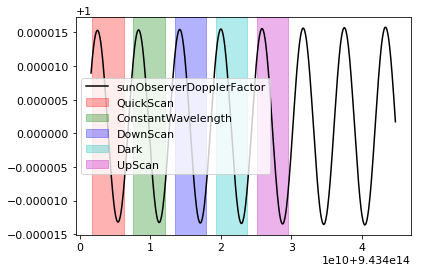

Shape: 
(27918, 2) 

Header: 
   microsecondsSinceGpsEpoch   intTime (ms)
0               9.434016e+14         1000.0
1               9.434016e+14         1000.0
2               9.434016e+14         1000.0
3               9.434016e+14         1000.0
4               9.434016e+14         1000.0 

Descriptive statistics: 
       microsecondsSinceGpsEpoch   intTime (ms)
count               2.791800e+04   27918.000000
mean                9.434156e+14    1038.433985
std                 8.058070e+09     552.809383
min                 9.434016e+14     250.000000
25%                 9.434086e+14     500.000000
50%                 9.434156e+14    1000.000000
75%                 9.434225e+14    1750.000000
max                 9.434295e+14    1750.000000 



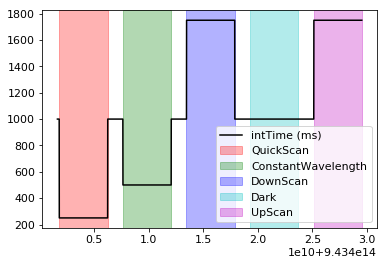

In [15]:
# Perform exploratory analysis on each dataframe
for df in list_df:
    df = exploreDataframe(df)

A few notes here:
* All dataframes share the same time format, but the sampling rate differs from that of the telemetry data.
* Temperature, distance and Doppler Factor are all cyclic, which should make interpolation easier.
* For integration time, there are only a handful of change points, which should make it easy to interpolate that quantity as well.

# Combining the Data

I'd like to have all this data in a single data frame to use for calculations.

In [16]:
# Start a data frame to store all values, including interpolated values
df_joined = df_telemetry.copy()

In [17]:
# Make a column for the plan name
df_joined['plan'] = np.nan

# Fill in the plan names column based on time limits
for i in range(df_plans.shape[0]):
    df_joined['plan'][(df_joined.microsecondsSinceGpsEpoch >= df_plans.startTime[i]) & (df_joined.microsecondsSinceGpsEpoch < df_plans.endTime[i])] = df_plans.planName[i]

In [18]:
print 'Number of null plan values: ', df_joined['plan'].isnull().sum()

Number of null plan values:  5801


### Interpolation

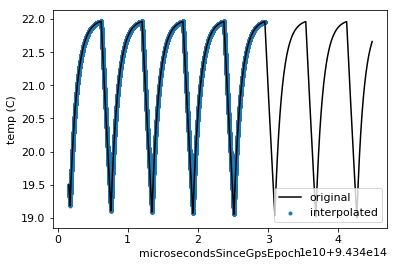

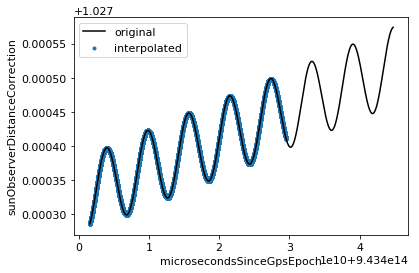

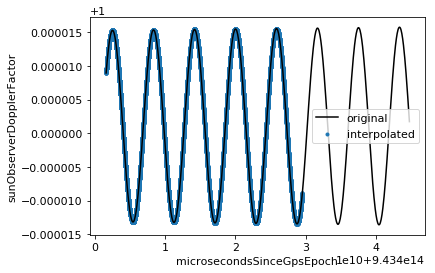

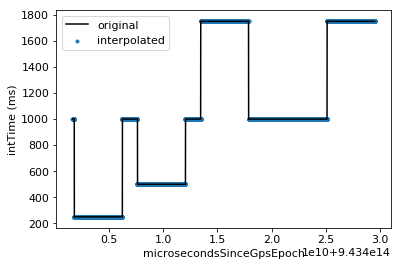

In [19]:
# for each dataframe, interpolate the values of each column
# sampled to match telemetry data
for df in list_df:
    for col in range(1, df.shape[1]):
        # inputs to interpOnTime are x, y, x_new, and method
        # use nearest for intTime, cubic for rest
        if df.columns[col] == 'intTime (ms)':
            kind = 'nearest'
        else:
            kind = 'cubic'
        interp_vals = interpOnTime(df.ix[:,0], df.ix[:,col], 
                                   df_joined.ix[:,0], kind)
        # add the column to the joined dataframe
        df_joined[df.columns[col]] = interp_vals
        # plot the original values
        plt.plot(df.ix[:,0], df.ix[:,col], color = 'black', 
                 label = 'original')
        # plot the interpolated values
        plt.scatter(df_joined.ix[:,0], interp_vals, marker = '.',
                    label = 'interpolated')
        plt.legend()
        plt.xlabel(df.columns[0])
        plt.ylabel(df.columns[col])
        plt.show()

In [20]:
# Drop the values that are outside of the experiment limits
df_data = df_joined.dropna()
print df_data.shape
df_data.head()

(36091, 8)


,microsecondsSinceGpsEpoch,gratPos,counts,plan,temp (C),sunObserverDistanceCorrection,sunObserverDopplerFactor,intTime (ms)
163,9.434018e+14,95415.099172,8.963950e+08,QuickScan,19.186577,1.027293,1.000011,250.0
164,9.434018e+14,95442.099172,8.398650e+08,QuickScan,19.187483,1.027293,1.000011,250.0
165,9.434018e+14,95469.099172,8.020883e+08,QuickScan,19.188290,1.027293,1.000011,250.0
166,9.434018e+14,95496.099172,8.207576e+08,QuickScan,19.189000,1.027293,1.000011,250.0
167,9.434018e+14,95523.099172,8.587132e+08,QuickScan,19.189657,1.027293,1.000011,250.0


# Data Corrections

These fall into three categories:
1) Removal of "dark" counts (varies with temperature),
2) Doppler correction,
3) Distance correction.

# Calculations of Irradiance

Using the equations given in the challenge, I'll calculate the wavelength and irradiance values.

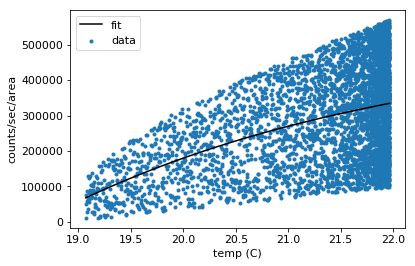

,microsecondsSinceGpsEpoch,gratPos,counts,plan,temp (C),sunObserverDistanceCorrection,sunObserverDopplerFactor,intTime (ms),CPSPA,cpspaCorrected,wavelength,wavelengthCorrected,irradiance
163,9.434018e+14,95415.099172,8.963950e+08,QuickScan,19.186577,1.027293,1.000011,250.0,3.585580e+11,3.490318e+11,189.965870,189.963797,0.003650
164,9.434018e+14,95442.099172,8.398650e+08,QuickScan,19.187483,1.027293,1.000011,250.0,3.359460e+11,3.270205e+11,189.931740,189.929666,0.003420
165,9.434018e+14,95469.099172,8.020883e+08,QuickScan,19.188290,1.027293,1.000011,250.0,3.208353e+11,3.123113e+11,189.897608,189.895534,0.003267
166,9.434018e+14,95496.099172,8.207576e+08,QuickScan,19.189000,1.027293,1.000011,250.0,3.283030e+11,3.195806e+11,189.863476,189.861402,0.003344
167,9.434018e+14,95523.099172,8.587132e+08,QuickScan,19.189657,1.027293,1.000011,250.0,3.434853e+11,3.343595e+11,189.829343,189.827269,0.003499


In [21]:
df_data = calcIrradiance(df_data)
df_data.head()

# Reference Spectrum

I'll take a quick look at the reference spectrum, then compare my calculations to the "ground truth" data.

In [22]:
global df_refSpectrum
df_refSpectrum = pd.read_csv(spectrum_file)

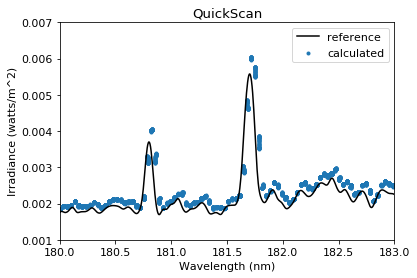

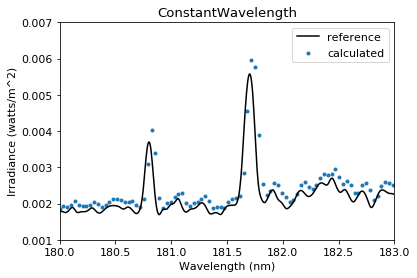

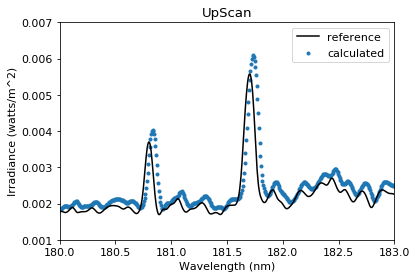

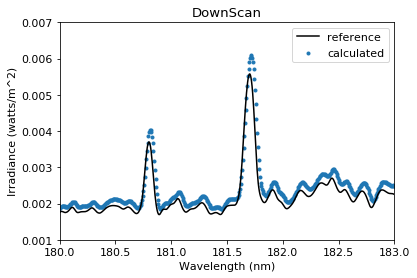

In [23]:
for planType in list(set(df_data['plan'])):
    if planType != 'Dark':
        plotReferenceSpectrum(df_data[df_data['plan']==planType])
        plt.title(planType)
        plt.show()